In [1]:
%pip install astropy
%pip install scipy
%pip install matplotlib
%pip install astroquery


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import astropy.io.fits as fits
from astropy.convolution import convolve, Gaussian2DKernel
from astropy.table import Table
from astropy.modeling.models import Moffat2D
import scipy.stats
import matplotlib.pyplot as plt
from datetime import datetime
from synthetic_image import (
    get_star_catalog,
    build_synthetic_wcs,
    world_to_pixel,
    mag_to_flux,
    add_psf_to_image,
    make_gaussian_psf,
    make_moffat_psf,
    sky_brightness_to_electrons,
    add_satellite_substepping
)

In [3]:
# Example: create a synthetic 512x512 image centered at RA=10°, Dec=20°,
# 1 arcsec/pix, no rotation, with a basic Gaussian PSF and random star positions

image_width = 4144
image_height = 2822

ra_center = 88.29533
dec_center = -5.364887
rotation_degrees = -52.0

max_mag = 19.5

seeing_arcsec = 5.5
pixscale_arcsec = .495

# Telescope & camera parameters (fictional example)
aperture_area      = 324.29      # cm^2
quantum_efficiency = 0.800
exposure_time      = 5.0     # seconds
sky_mag_per_arcsec2 = 18.5    # dark-ish sky
mag_zero_point     = 15.5

In [4]:
# 1) Build a WCS
wcs_obj, wcs_header = build_synthetic_wcs(
    image_width,
    image_height,
    ra_center,
    dec_center,
    pixscale_arcsec=pixscale_arcsec,
    rotation_degrees=rotation_degrees
)

In [5]:
# 2) Create an empty image
synthetic_image = np.zeros((image_height, image_width), dtype=float)

In [6]:
# 3) Retrieve some real star positions (requires network)
star_catalog = get_star_catalog(ra_center, dec_center, radius=0.4, max_mag=max_mag)
fwhm_pixels = seeing_arcsec / pixscale_arcsec

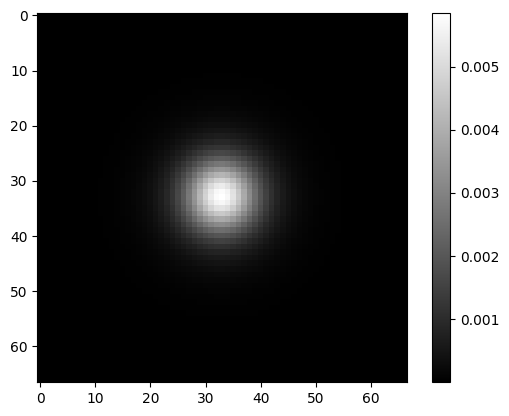

In [7]:
# 4) Make a PSF
# psf_kernel = make_gaussian_psf(size=fwhm_pixels * 8, fwhm=fwhm_pixels)
psf_kernel = make_moffat_psf(
    size=fwhm_pixels * 6,          # total kernel size in pixels
    fwhm=fwhm_pixels,         # FWHM in pixels
    moffat_alpha=4  # shape index
)

#plot the PSF
plt.imshow(psf_kernel, cmap='gray')
plt.colorbar()
plt.show()

In [8]:
# Let's define a start/end RA/Dec that crosses roughly the center of your existing field:
# For demonstration, pick something near your center at (ra_center, dec_center)
# We'll move ~0.07 degrees in RA (a few arcminutes) during the same exposure time as stars.

# REPLACE or TWEAK these as desired:
sat_start_ra = ra_center - 0.03   # start slightly west
sat_start_dec = dec_center
sat_end_ra = ra_center + 0.04     # end slightly east, crossing center
sat_end_dec = dec_center

# Suppose we want a total flux akin to a ~mag 9 satellite over the 5s exposure
# We'll estimate flux similarly to how we do for a star:
sat_mag = 12.0

# sat_mag_atm_corrected = sat_mag + 1.0  # Isn't this already corrected?
sat_flux_electrons = mag_to_flux(
    mag=sat_mag,
    exposure_time=exposure_time,
    aperture_area=aperture_area,
    quantum_efficiency=quantum_efficiency,
    mag_zero_point=mag_zero_point
)

# We'll use 30 sub-steps so the path is fairly smooth
num_sub_steps = 3000

# Add the satellite to the existing 'noisy_image' or 'synthetic_image'
# Let's add it to the raw 'synthetic_image' BEFORE we do noise, so we can incorporate it into the final noise model
add_satellite_substepping(
    image=synthetic_image,       # or noisy_image if you prefer
    wcs_obj=wcs_obj,
    start_ra_deg=sat_start_ra,
    start_dec_deg=sat_start_dec,
    end_ra_deg=sat_end_ra,
    end_dec_deg=sat_end_dec,
    total_exposure_s=exposure_time,
    total_satellite_flux=sat_flux_electrons,
    psf_kernel=psf_kernel,
    num_steps=num_sub_steps
)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(2822, 4144))

In [9]:
# 5) Add sky background
sky_bg = sky_brightness_to_electrons(
    sky_mag_per_arcsec2,
    plate_scale_arcsec_per_pix=.495,  # matches our WCS scale
    exposure_time=exposure_time,
    quantum_efficiency=quantum_efficiency,
    aperture_area=aperture_area,
    mag_zero_point=mag_zero_point
)

synthetic_image += sky_bg

In [10]:
# 6) Add stars
if star_catalog is not None:
    for star in star_catalog:
        x_star, y_star = wcs_obj.all_world2pix(star['RA'], star['Dec'], 0)
        # Some simple atmospheric extinction
        extinction = 1.3
        mag_atm_corrected = star['Mag'] + extinction
        flux_electrons = mag_to_flux(
            mag_atm_corrected,
            exposure_time,
            aperture_area,
            quantum_efficiency,
            mag_zero_point
        )
        synthetic_image = add_psf_to_image(synthetic_image, x_star, y_star, flux_electrons, psf_kernel)

In [11]:
# 7) (Optional) Add Poisson and read noise
read_noise_e = 5.0  # e- RMS
noisy_image = np.random.poisson(synthetic_image) \
                + np.random.normal(loc=0.0, scale=read_noise_e, size=synthetic_image.shape)


noisy_image = np.fliplr(noisy_image)

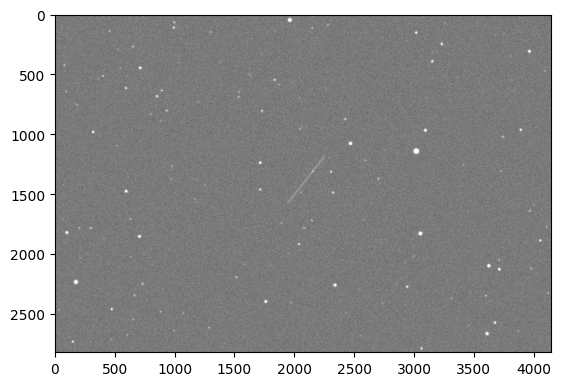

In [12]:
# plot the image with scaling
plt.imshow(noisy_image, cmap='gray', vmin=np.percentile(noisy_image, 0.5), vmax=np.percentile(noisy_image, 99.5))
plt.show()

In [13]:
# 8) Save to a FITS file
# Name the file with the current timestamp
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

wcs_header["EXPTIME"] = (exposure_time, "Exposure time in seconds")
wcs_header["DATE-OBS"] = (datetime.utcnow().strftime("%Y-%m-%dT%H:%M:%S"), "UTC date/time of observation start")
wcs_header["TELESCOP"] = ("Simulator", "Telescope name")
wcs_header["PIXSCALE"] = (pixscale_arcsec, "Plate scale in arcsec/pixel")
wcs_header["RA"] = (ra_center, "Right Ascension in degrees")
wcs_header["DEC"] = (dec_center, "Declination in degrees")
wcs_header["RADECSYS"] = ("ICRS", "Right Ascension and Declination system")

hdu = fits.PrimaryHDU(data=noisy_image, header=wcs_header)
hdu.writeto(f"output/synthetic_image_{timestamp}.fits", overwrite=True)
print(f"Synthetic image saved to synthetic_image_{timestamp}.fits")

Synthetic image saved to synthetic_image_20250116_112734.fits
